# CPE494/663 GENERATIVE ARTIFICIAL INTELLIGENCE
## Lab 1: PyTorch Discriminative Model

### Download dataset

Using `RealWaste` dataset from https://archive.ics.uci.edu/dataset/908/realwaste  
The dataset contains 4752 images of waste items across 9 material types.

In [1]:
import requests
import zipfile
from pathlib import Path
from io import BytesIO

In [2]:
%%time
if not Path("realwaste-main").is_dir():
    print("Downloading dataset...")
    resp = requests.get("https://archive.ics.uci.edu/static/public/908/realwaste.zip")
    content = BytesIO(resp.content)
    with zipfile.ZipFile(content, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Downloaded and extracted dataset to `./realwaste-main`")
else:
    print("Dataset already exists")

Downloaded and extracted dataset to `./realwaste-main`
CPU times: user 4.83 s, sys: 2.73 s, total: 7.57 s
Wall time: 1min


### Define `datasets` and `DataLoader`

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

In [4]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
resolution = 128
# Define data transformation
data_transforms = transforms.Compose([transforms.Resize((resolution, resolution)),
                                      transforms.ToTensor()
                                     ])

In [33]:
# Read image directory as dataset
realwaste_img = datasets.ImageFolder("realwaste-main/RealWaste/",
                                     transform=data_transforms)

In [34]:
# Get number of classes in the dataset
num_classes = len(realwaste_img.classes)
print(f"Dataset contains {num_classes} classes: {realwaste_img.classes}")

Dataset contains 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [35]:
# Split dataset into training and test set
train_ratio = 0.7

train_size = int(train_ratio * len(realwaste_img))
test_size = len(realwaste_img) - train_size

train_dataset, test_dataset = random_split(realwaste_img,
                                           [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

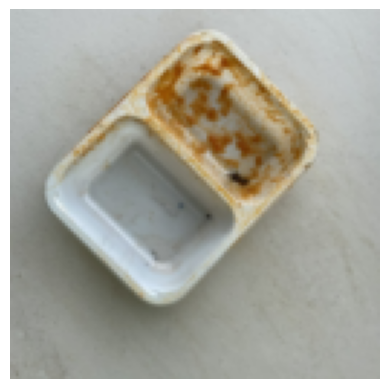

Label: Plastic


In [36]:
# Show sample image from training set
import matplotlib.pyplot as plt
import numpy as np

def show_image(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
show_image(images[0])
print(f"Label: {realwaste_img.classes[labels[0]]}")

### Modeling

**Your turn:** Develop and train a discriminative neural network to classify images within the `RealWaste` dataset.  
You can use any neural network architecture; however, you must provide a technical justification for your design choices.  
Evaluate the model's performance using appropriate loss functions and metrics.  

**What to submit:** 2 files:
1. A Python notebook (.ipynb)
2. Export your notebook as a PDF file
   
Submit to `Lab 1 - PyTorch` activity in LEB2.  


**Due date:** 26/01/2026 17:59

# ResNet50
baseline code

In [11]:
import torch
import torch.nn as nn

class StandardBottleneck(nn.Module):
    expansion = 4  # The output is always 4x the input planes
    # this basicly help resnet to stack infinitely as this block help expanding the feature map

    def __init__(self, in_planes, planes, stride=1):
        super(StandardBottleneck, self).__init__()
        # 1. Squeeze: 1x1 conv to reduce dimensions
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 2. Process: 3x3 conv for spatial features
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 3. Expand: 1x1 conv to restore dimensions (x4)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.relu = nn.ReLU(inplace=True)

        # Shortcut handling (if dimensions change, we need to adapt the residual)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        # Add the residual (original input + processed output)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_planes = 64

        # Initial Stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # The 4 Layers (Stages)
        # Structure: [3 blocks, 4 blocks, 6 blocks, 3 blocks]
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes) # 512*4 = 2048 input features

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(StandardBottleneck(self.in_planes, planes, stride))
            self.in_planes = planes * 4
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# EfficientNet Scaling for ResNet50
I initially selected ResNet50 as a baseline architecture because its use of residual connections solves the vanishing gradient problem

However, I observed that the model was too complex for the dataset, resulting in overfitting

 To correct this, I applied the compound scaling principles from EfficientNet but inverted the logic: by setting the scaling coefficient $\phi$ to -4, I mathematically shrank the model’s depth, width, and resolution in a balanced ratio, ensuring the network retained its structural integrity

 I further optimized this by removing the final 512 and 256-node convolutional block, which is the most parameter-heavy section of ResNet and often unnecessary for tasks simpler than ImageNet.

And I notice on how gradient of training set is shrinking rapidly. So to prevent the optimizer from overshooting during training, I reduced the learning rate to 5e-4, ensuring smoother convergence.

In [28]:
import torch
import torch.nn as nn
import math

# ---------------------------------------------------------
# 1. Helper Functions for Scaling
# ---------------------------------------------------------

def make_divisible(v, divisor=8, min_value=None):
    """
    Ensures all layer channels are divisible by 8 (friendly to hardware).
    Adapted from the original EfficientNet implementation.
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def get_compound_params(phi):
    """
    Calculates the depth, width, and resolution multipliers
    based on the compound coefficient phi.

    EfficientNet Constants:
    alpha = 1.2 (depth)
    beta  = 1.1 (width)
    gamma = 1.15 (resolution)
    """
    alpha, beta, gamma = 1.2, 1.1, 1.15

    depth_mult = alpha ** phi
    width_mult = beta ** phi
    res_mult   = gamma ** phi

    return depth_mult, width_mult, res_mult

# ---------------------------------------------------------
# 2. Standard ResNet Components (Bottleneck)
# ---------------------------------------------------------

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [29]:
class ScaledResNet(nn.Module):
    def __init__(self, block, layers, width_mult=1.0, num_classes=1000,
                 zero_init_residual=False, groups=1, width_per_group=64):
        super(ScaledResNet, self).__init__()

        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        # Base settings
        self.inplanes = make_divisible(64 * width_mult)
        self.base_width = width_per_group
        self.groups = groups

        # Initial Stem (Scale the stem width too)
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Calculate scaled channel widths for the 4 stages
        # Base ResNet planes are [64, 128, 256, 512]
        layer_planes = [
            make_divisible(64 * width_mult),
            make_divisible(128 * width_mult),
            make_divisible(256 * width_mult),
            make_divisible(512 * width_mult)
        ]

        # Create layers
        self.layer1 = self._make_layer(block, layer_planes[0], layers[0])
        self.layer2 = self._make_layer(block, layer_planes[1], layers[1], stride=2)
        # self.layer3 = self._make_layer(block, layer_planes[2], layers[2], stride=2)
        # self.layer4 = self._make_layer(block, layer_planes[3], layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final fully connected layer
        final_channels = layer_planes[1] * block.expansion
        self.fc = nn.Linear(final_channels, num_classes)

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None

        # If stride != 1 or input channels != output channels, we need a downsample projection
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [30]:
# ---------------------------------------------------------
# 4. Builder Function
# ---------------------------------------------------------

def efficient_scaled_resnet50(phi=0, num_classes=1000):
    """
    Constructs a ResNet-50 model scaled using EfficientNet compound scaling.

    Args:
        phi (int): The compound scaling coefficient (e.g., 0 for base, 1, 2...).
                   phi=0 is standard ResNet50.
    """
    # 1. Get multipliers
    d_mult, w_mult, r_mult = get_compound_params(phi)

    # 2. Scale Depth (ResNet50 base layers: [3, 4, 6, 3])
    base_layers = [3, 4, 6, 3]
    # We use ceiling to round up layers, ensuring we don't lose depth on small scales
    scaled_layers = [int(math.ceil(l * d_mult)) for l in base_layers]

    # 3. Scale Resolution (Target Input Size)
    base_res = 224
    target_res = int(base_res * r_mult)

    print(f"--- Efficient Scaled ResNet50 (Phi={phi}) ---")
    print(f"Depth Multiplier: {d_mult:.2f} -> Layers: {scaled_layers}")
    print(f"Width Multiplier: {w_mult:.2f}")
    print(f"Target Resolution: {target_res}x{target_res}")

    # 4. Build Model
    model = ScaledResNet(
        block=Bottleneck,
        layers=scaled_layers,
        width_mult=w_mult,
        num_classes=num_classes
    )

    return model, target_res

#### Model Structure

In [ ]:
model = ResNet50(num_classes=num_classes)

# Test with a dummy input of the calculated resolution
dummy_input = torch.randn(1, 3, 64, 64)
output = model(dummy_input)
model.to(device)

In [37]:
# Example: Create a Phi=1 scaled ResNet50 (roughly "ResNet-50-B1")
model, resolution = efficient_scaled_resnet50(phi=-4, num_classes=num_classes)

# Test with a dummy input of the calculated resolution
dummy_input = torch.randn(1, 3, resolution, resolution)
output = model(dummy_input)
model.to(device)

print(f"Output shape: {output.shape}")

--- Efficient Scaled ResNet50 (Phi=-4) ---
Depth Multiplier: 0.48 -> Layers: [2, 2, 3, 2]
Width Multiplier: 0.68
Target Resolution: 128x128
Output shape: torch.Size([1, 9])


In [38]:
print(model)

ScaledResNet(
  (conv1): Conv2d(3, 40, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(40, 160, kernel_size=(1, 1), strid

#### Parameter Count

In [39]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 371,953


### Training and Evaluation

In [40]:
import torch.optim as optim
import torch.nn.functional as F

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Number of epochs
num_epochs = 10

print(f"Training on: {device}")

Training on: cuda


In [41]:
%%time
from tqdm.auto import tqdm

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")
    for i, data in enumerate(train_bar):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_train_loss_avg = running_loss / (i + 1)
        current_train_acc = 100 * correct_train / total_train
        train_bar.set_postfix(loss=f'{current_train_loss_avg:.3f}', acc=f'{current_train_acc:.2f}%')

    # Evaluation loop
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        test_bar = tqdm(test_loader, desc=f"Epoch {epoch + 1} Validation")
        for i, data in enumerate(test_bar):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            current_test_loss_avg = test_loss / (i + 1)
            current_test_acc = 100 * correct_test / total_test
            test_bar.set_postfix(loss=f'{current_test_loss_avg:.3f}', acc=f'{current_test_acc:.2f}%')

    # Print epoch summary after loops complete
    train_accuracy_final = 100 * correct_train / total_train
    test_accuracy_final = 100 * correct_test / total_test
    print(f'Epoch {epoch + 1} Summary: Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {train_accuracy_final:.2f}%, Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy_final:.2f}%\n')

print('Finished Training')

Epoch 1 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 Summary: Training Loss: 1.553, Training Accuracy: 46.57%, Test Loss: 1.724, Test Accuracy: 37.66%



Epoch 2 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 Summary: Training Loss: 1.147, Training Accuracy: 60.70%, Test Loss: 1.424, Test Accuracy: 46.84%



Epoch 3 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3 Summary: Training Loss: 1.022, Training Accuracy: 64.13%, Test Loss: 2.737, Test Accuracy: 24.47%



Epoch 4 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4 Summary: Training Loss: 0.950, Training Accuracy: 64.82%, Test Loss: 3.548, Test Accuracy: 23.42%



Epoch 5 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5 Summary: Training Loss: 0.894, Training Accuracy: 68.52%, Test Loss: 2.929, Test Accuracy: 29.10%



Epoch 6 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6 Summary: Training Loss: 0.798, Training Accuracy: 71.89%, Test Loss: 1.254, Test Accuracy: 54.77%



Epoch 7 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7 Summary: Training Loss: 0.741, Training Accuracy: 73.36%, Test Loss: 1.326, Test Accuracy: 53.72%



Epoch 8 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8 Summary: Training Loss: 0.722, Training Accuracy: 74.11%, Test Loss: 2.649, Test Accuracy: 36.33%



Epoch 9 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9 Summary: Training Loss: 0.667, Training Accuracy: 76.40%, Test Loss: 4.652, Test Accuracy: 27.56%



Epoch 10 Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10 Summary: Training Loss: 0.663, Training Accuracy: 77.03%, Test Loss: 1.113, Test Accuracy: 60.73%

Finished Training
CPU times: user 4min 35s, sys: 3.56 s, total: 4min 38s
Wall time: 4min 41s


---

Starting Evaluation...


Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]


Evaluation Results
F1 Macro Score: 0.6041
------------------------------
Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.68      0.57       147
           1       0.84      0.66      0.74       128
           2       0.60      0.84      0.70       133
           3       0.79      0.53      0.63       222
           4       0.44      0.54      0.48       152
           5       0.51      0.83      0.63       149
           6       0.75      0.50      0.60       274
           7       0.46      0.35      0.40       103
           8       0.73      0.63      0.68       118

    accuracy                           0.61      1426
   macro avg       0.63      0.62      0.60      1426
weighted avg       0.64      0.61      0.61      1426



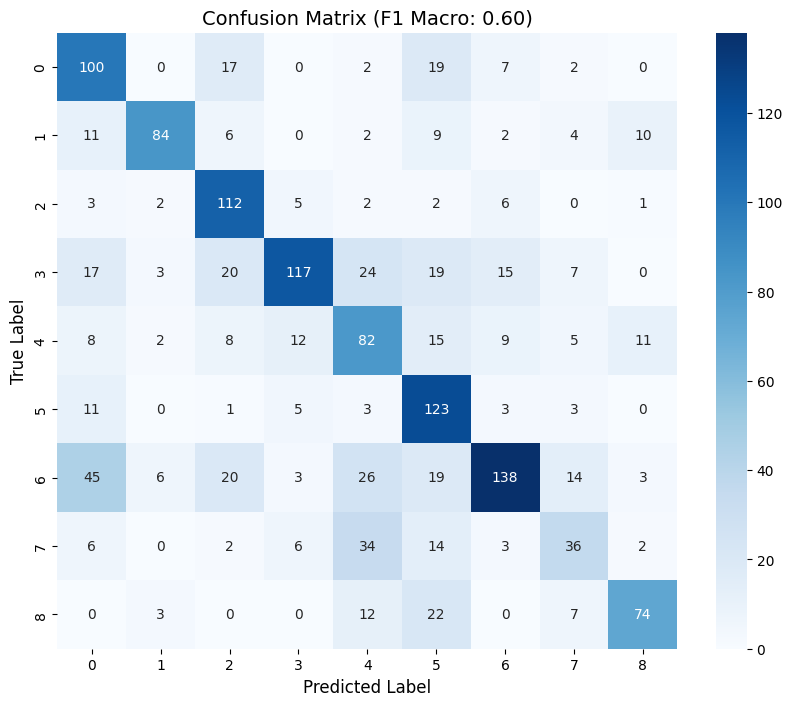

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm

def evaluate_model(model, data_loader, device, class_names=None):
    """
    Evaluates the model on the provided data_loader and plots a confusion matrix.

    Args:
        model: The trained PyTorch model.
        data_loader: The validation/test DataLoader.
        device: 'cuda' or 'cpu'.
        class_names: (Optional) List of class names for the plot axis labels.
    """
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_targets = []

    print("Starting Evaluation...")

    with torch.no_grad():  # Disable gradient calculation
        # Iterate over the data loader
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions (class with highest probability)
            _, predicted = torch.max(outputs, 1)

            # Move to CPU and convert to numpy for sklearn
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # --- Metrics Calculation ---

    # 1. F1 Macro Score
    f1_macro = f1_score(all_targets, all_preds, average='macro')

    # 2. Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)

    # 3. Text Report (Precision, Recall, F1 for every class)
    report = classification_report(all_targets, all_preds, target_names=class_names)

    print("\n" + "="*30)
    print(f"Evaluation Results")
    print("="*30)
    print(f"F1 Macro Score: {f1_macro:.4f}")
    print("-" * 30)
    print("Detailed Classification Report:\n")
    print(report)

    # --- Plotting Confusion Matrix ---
    plt.figure(figsize=(10, 8))

    # Create Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix (F1 Macro: {f1_macro:.2f})', fontsize=14)
    plt.show()

# --- Usage Example ---

# 1. Define your class names (optional, but makes the plot readable)
# Replace these with your actual dataset classes, e.g., ['cat', 'dog', 'bird']
# If you don't have names, you can pass None or generate a list of numbers.
class_names = [str(i) for i in range(1000)] # Example for ImageNet-1k, change as needed

# 2. Run the evaluation
# Ensure 'model' and 'test_loader' are defined from your previous steps
evaluate_model(model, test_loader, device, class_names=None)